In [1]:
import os, sys, wave, struct

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import IPython

from copy import deepcopy
from math import ceil, exp, atan, pi, cos, sin
from scipy.io.wavfile import write
#import scipy.io.wavfile
from scipy.linalg import hankel
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

import pylab as p
#import matplotlib.axes3d as p3
import mpl_toolkits.mplot3d.axes3d as p3

# Useful functions

In [2]:
def load_sound(file):
    return wave.open(file, 'rb')

def plot_sound(data, times,xlim1,xlim2,name='default_name', save=False,w=20,h=10, lw = 3):
    plt.figure(figsize=(w, h))
    plt.plot(times,x.reshape(len_x))
    plt.xlim(xlim1,xlim2)
    plt.xlabel('time (s)')
    plt.ylabel('amplitude')
    if save:
        plt.savefig(name+'.png', dpi=100)
    plt.show()
    
def read_values(filename):
    wave_file = wave.open(filename, 'r')
    nframes = wave_file.getnframes()
    nchannels = wave_file.getnchannels()
    sampling_frequency = wave_file.getframerate()
    T = nframes / float(sampling_frequency)
    read_frames = wave_file.readframes(nframes)
    wave_file.close()
    data = struct.unpack("%dh" %  nchannels*nframes, read_frames)
    
    data_per_channel = [data[offset::nchannels] for offset in range(nchannels)]
    return T, np.array(data_per_channel), nframes, nchannels, sampling_frequency

In [3]:
def Synthesis(N,delta,f,a,phi,RSB=False):
    t = range(N)
    logz = delta + 1j*2*np.pi*f
    alpha = a*np.exp(1j*phi)
    x = np.sum(np.outer(alpha, np.ones(N))*np.exp(np.outer(logz,t)), axis=0)
    if RSB == False: 
        s = x
    else: 
        Ex = np.real(np.sum(np.abs(x)**2))/N
        b = np.random.normal(size=N) + 1j*np.random.normal(size=N)
        Eb = np.real(np.sum(np.abs(b)**2))/N
        b = b*np.sqrt(Ex/Eb)*10**(-RSB/20)
        s = x+b    
    return s

# Open audio file

In [4]:
wavefile = load_sound('ClocheB.WAV')
print(wavefile.getparams())

_wave_params(nchannels=1, sampwidth=2, framerate=8000, nframes=99414, comptype='NONE', compname='not compressed')


In [5]:
IPython.display.Audio('ClocheB.WAV')

In [6]:
T, data, nframes, nchannels, sampling_frequency = read_values('ClocheA.WAV')
Fs = int(wavefile.getframerate())
x = np.array(data)
num_samples = int(wavefile.getnframes())

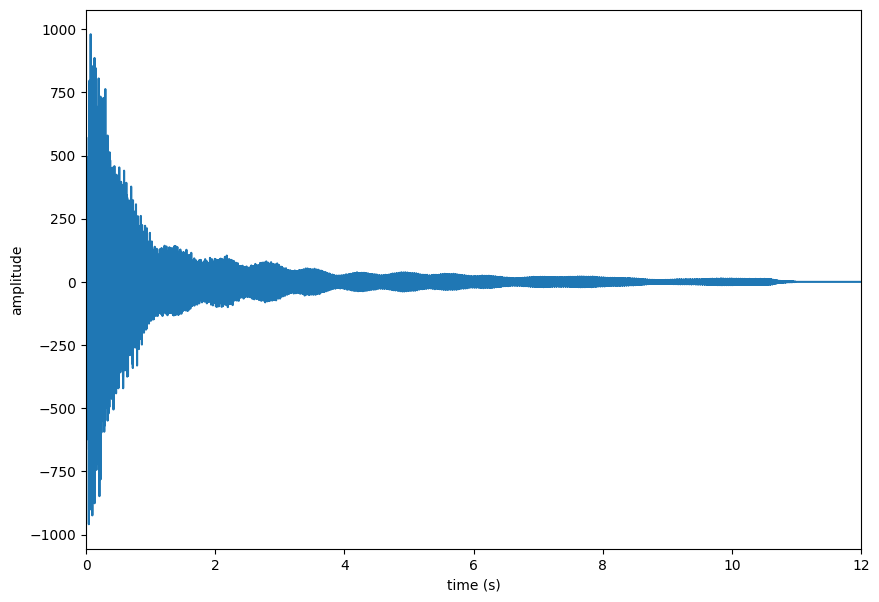

In [7]:
len_x = x.shape[1]
timestep = 1/(float(Fs))
times = np.arange(len_x)*timestep # int(len_x/6)
plot_sound(x.reshape(len_x), times,0,12,w=10,h=7)

In [8]:
write('new_bell.wav', Fs, np.array(x.reshape(len_x), dtype=np.int16)) # to write a new wave file

In [9]:
N = 63
delta = [0,-0.05]
f = [1/4 , 1/4 + 1/N]
f  = np.array(f,dtype=complex)
a  = [1,10]
phi = np.linspace(-np.pi,np.pi,2)
x = Synthesis(N,delta,f,a,phi)
print("frequencies: ", f)
print("amplitudes: ", a)
print("phases: ", phi)

frequencies:  [0.25      +0.j 0.26587302+0.j]
amplitudes:  [1, 10]
phases:  [-3.14159265  3.14159265]


### 3.2 High resolution methods
#### 1 . Computation of the empirical covariance matrix

In [10]:
def covariance_matrix(x):
    _,l = np.shape(x)
    return np.dot(x,x.T)/l
n = 32 
l = N - n + 1
X = hankel(x[:n],x[n-1:len_x])
cov = covariance_matrix(X)
print(np.shape(cov))
U1,D, U2 = np.linalg.svd(cov)
print(np.shape(U1),np.shape(D),np.shape(U2))


(32, 32)
(32, 32) (32,) (32, 32)


In [ ]:
def ESPRIT(W):
    Wup = W[:-1,:]
    Wlow = W[1:,:]
    Phi = np.dot(np.linalg.pinv(Wup),Wlow)
    eigen_values = np.linalg.eigvals(Phi)
    delta = np.log(np.abs(eigen_values))
    f = np.angle(eigen_values)/(2*np.pi)
    return delta,f


def LeastSquares(X,delta,f):
    
    lnV = np.dot(np.matrix(np.arange(X.shape[0])).T,np.matrix(delta) + 1j*2*np.pi*np.matrix(f))
    V = np.exp(lnV)
    A = np.dot(np.linalg.pinv(V),X)
    return np.abs(A) , np.angle(A)

W = U1[:,:2]
delta,f = ESPRIT(W)
print("delta : " , (delta), "f : " , f)
A,phi = LeastSquares(x[:n],delta,f)
print("alphas:" , A)
print("phases:" , phi)

delta :  [-5.00000000e-02 -1.88737914e-15] f :  [0.26587302 0.25      ]
alphas: [[10.  1.]]
phases: [[ 3.14159265 -3.14159265]]


### 3.2.2 Music Method
#### 6. Music pseudo-spectrum

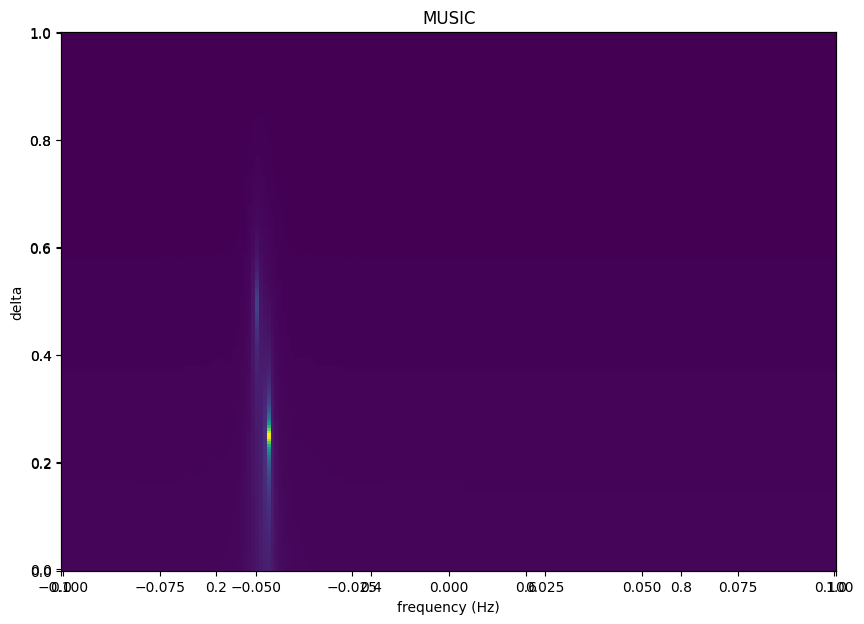

In [12]:
def Music(x,n,K):
    X = hankel(x[:n],x[n-1:N])
    cov = covariance_matrix(X)
    U1,D, U2 = np.linalg.svd(cov)
    Wo = U1[:,K:]
    WoH = np.conjugate(Wo.T)
    f = np.linspace(0,1,200)
    delta = np.linspace(-0.1,0.1,200)
    P = np.zeros((len(f),len(delta)))
    for i in range(len(f)):
        for j in range(len(delta)):
            Vn = np.exp(np.matrix(np.arange(n)).T*(delta[j] + 1j*2*np.pi*f[i]))
            P[i,j] = 1/np.linalg.norm(np.dot(WoH, Vn))
              
    
    f,delta = np.meshgrid(f,delta)
    fig,ax = plt.subplots(1,1,figsize=(10,7))
    ax = fig.add_subplot(111)
    ax.pcolormesh(delta,f,P)
    plt.xlabel('frequency (Hz)')
    plt.ylabel('delta')
    plt.title('MUSIC')
    plt.show()
    return P


P = Music(x,n,2)


# 4. Audio signals
## 4.2 Spectral analysis by Fourier transform

In [13]:
T, data, nframes, nchannels, sampling_frequency = read_values('ClocheA.WAV')
FsA = int(wavefile.getframerate())
clocheA= np.array(data)
num_samples = int(wavefile.getnframes())
periodogramA = np.abs(np.fft.fft(clocheA))**2


In [14]:
T, data, nframes, nchannels, sampling_frequency = read_values('ClocheB.WAV')
FsB = int(wavefile.getframerate())
clocheB= np.array(data)
num_samples = int(wavefile.getnframes())
periodogramB = np.abs(np.fft.fft(clocheB))**2



In [15]:
print(np.shape(periodogramA),np.shape(periodogramB))

(1, 95997) (1, 99414)


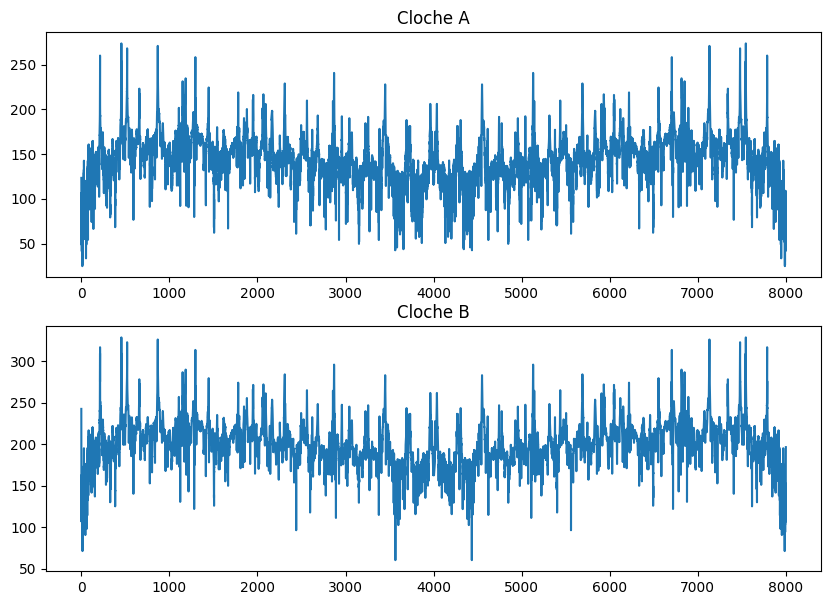

In [16]:
plt.figure(figsize=(10,7))
plt.subplot(2,1,1)
plt.plot(np.linspace(0,FsA,len(clocheA[0,:])),10*np.log(periodogramA[0,:]))
plt.title('Cloche A')
plt.subplot(2,1,2)
plt.plot(np.linspace(0,FsB,len(clocheB[0,:])),10*np.log(periodogramB[0,:]))
plt.title('Cloche B')
plt.show()

32000


(512, 512)
(512, 512) (512,) (512, 512)


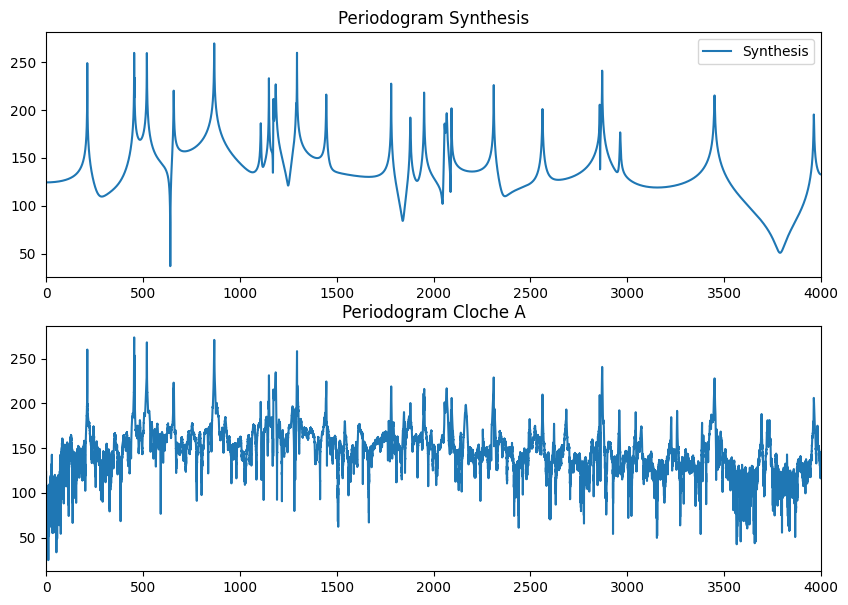

32000 32000


In [17]:
K = 54
n = 512
l = 1024
N = 4*FsA


sample = clocheA[0,1000:1000+N]
print(N)


X = hankel(sample[:n],sample[n-1:len_x])
cov = covariance_matrix(X)
print(np.shape(cov))
U1,D, U2 = np.linalg.svd(cov)
print(np.shape(U1),np.shape(D),np.shape(U2))
W = U1[:,:K]
delta,f = ESPRIT(W)
A,phi = LeastSquares(sample[:n],delta,f)

synthesis = Synthesis(N, delta, f, np.array(A).flatten(), np.array(phi).flatten())
periodograms = np.abs(np.fft.rfft(np.real(synthesis)))**2
plt.figure(figsize=(10,7))
plt.subplot(2,1,1)
plt.plot(np.fft.rfftfreq(N,1/FsA),10*np.log(periodograms),label= "Synthesis")

plt.legend()
plt.title('Periodogram Synthesis')
plt.xlim(0,FsA/2)
plt.subplot(2,1,2)
plt.plot(np.linspace(0,FsA,len(clocheA[0,:])),10*np.log(periodogramA[0,:]), label='Cloche A')
plt.title('Periodogram Cloche A')
plt.xlim(0,FsA/2)

plt.show()
print(len(synthesis),len(sample))
write('clocheAsynth.wav', FsA, np.array(np.real(synthesis), dtype=np.int16)) # to write a new wave file
# 1535 samples for 3 seconds Fs =51200
IPython.display.Audio('clocheAsynth.wav')


In [18]:
print(delta)

[-6.49550060e-04 -6.49550060e-04 -8.34658674e-04 -8.34658674e-04
 -9.25929927e-04 -9.25929927e-04 -2.81511382e-04 -2.81511382e-04
 -2.76737215e-04 -2.76737215e-04 -6.25876631e-04 -6.25876631e-04
 -2.46020553e-04 -2.46020553e-04 -2.63540720e-04 -2.63540720e-04
 -1.23854782e-03 -1.23854782e-03 -9.30585280e-04 -9.30585280e-04
 -2.88875261e-04 -2.88875261e-04 -5.38422946e-04 -5.38422946e-04
 -1.68967406e-04 -1.68967406e-04 -4.23001747e-04 -4.23001747e-04
 -6.36753350e-05 -6.36753350e-05 -3.72992044e-04 -3.72992044e-04
 -1.62777675e-04 -1.62777675e-04 -6.15469764e-05 -6.15469764e-05
 -7.79591244e-05 -7.79591244e-05 -2.94199825e-04 -2.94199825e-04
 -1.09340037e-03 -1.09340037e-03 -9.25095478e-05 -9.25095478e-05
 -8.57980995e-04 -8.57980995e-04 -6.26770152e-04 -6.26770152e-04
 -1.41899132e-04 -1.41899132e-04 -7.17914999e-04 -7.17914999e-04
 -2.53155745e-04 -2.53155745e-04]


In [19]:
print(FsA)

8000


(512, 512)
(512, 512) (512,) (512, 512)


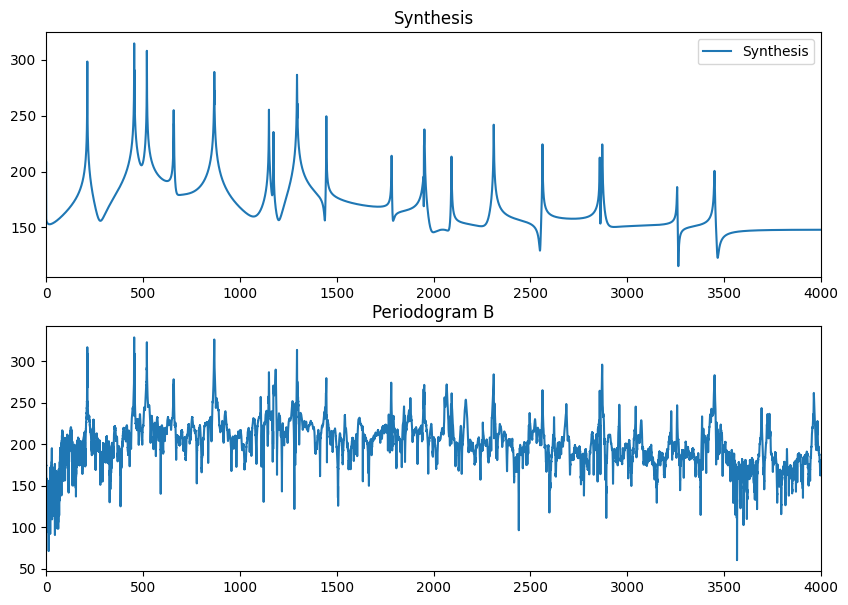

In [20]:



K = 54
n = 512
l = 1024
N = 4*FsB

sample2 = clocheB[0,10000:10000+N]


X = hankel(sample2[:n],sample2[n-1:len_x])
cov = covariance_matrix(X)
print(np.shape(cov))
U1,D, U2 = np.linalg.svd(cov)
print(np.shape(U1),np.shape(D),np.shape(U2))
W = U1[:,:K]
delta,f = ESPRIT(W)
A,phi = LeastSquares(sample2[:n],delta,f)

synthesis = Synthesis(N, delta, f, np.array(A).flatten(), np.array(phi).flatten())
periodograms = np.abs(np.fft.rfft(np.real(synthesis)))**2
plt.figure(figsize=(10,7))
plt.subplot(2,1,1)
plt.plot(np.fft.rfftfreq(N,1/FsB),10*np.log(periodograms),label= "Synthesis")
plt.xlim(0,FsB/2)
plt.legend()
plt.title('Synthesis')
plt.subplot(2,1,2)
plt.plot(np.linspace(0,FsB,len(clocheB[0,:])),10*np.log(periodogramB[0,:]), label='Cloche B')
plt.title('Periodogram B')
plt.xlim(0,FsB/2)

plt.show()

write('clocheBsynth.wav', FsB, np.array(np.real(synthesis), dtype=np.int16)) # to write a new wave file
IPython.display.Audio('clocheBsynth.wav')
